## Final Project Submission - Book 3

Please fill out:
* Student name: Dicchyant Gurung
* Student pace: Self paced 
* Scheduled project review date/time: 6/9/2021
* Instructor name: Jeff Herman
* Blog post URL:https://dicchyanttamu.wixsite.com/data/post/line-graph-visualization


### Business Case

The Vehicle Safety Board is looking to reduce the number of accidents in the City of Chicago. Utilizing the car crash data received from the Chicago Data Portal, we will perform some meaningful EDA and provide recommendations to the Vehicle Safety Board.

Firstly, we will do some data exploration to answer the following three problem statements. We will then use the results to identify areas for improvement and come up with actionable steps that will help reduce the number of accidents in the City of Chicago.

**1. Identify high-density areas of car crash in Chicago**

**2. Analyze control failures to identify opportunities for improvement**

**3. Check for trends in the time of crash to relocate resources appropriately**

Furthermore, we will create a classifier to categorize the accidents in two main cateogories for future references:

**1. Unintentional:** These are events or instances where the driver was unaware of the possibility of an accident.

**2. Intentional:** These are events or instances where the driver was fully aware of the possibility of an accident.

### Book 3:  Create a classifier to categorize the car crashes in two main cateogories

> **1. Unintentional:** These are events or instances where the driver was unaware of the possibility of an accident.

> **2. Intentional:** These are events or instances where the driver was fully aware of the possibility of an accident.

### Import relevant packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score, \
mean_squared_error, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Import cleaned data

In [2]:
df_final = pd.read_csv('car_crash_final.csv')

In [3]:
df_final.shape

(404326, 21)

In [4]:
df_final.AGE

0         37
1         32
2         37
3         41
4         50
          ..
404321    20
404322    71
404323    59
404324    21
404325    40
Name: AGE, Length: 404326, dtype: int64

In [5]:
# We need the age columns as objects since we are looking to classify them. We will tranform them in string
df_final.AGE = df_final.AGE.map(lambda x : str(x))

### Prepare the data

In [6]:
X = df_final.drop(['PRIM_CONTRIBUTORY_CAUSE', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LONGITUDE', 'LATITUDE', 'LOCATION'], axis=1).copy()
y = df_final.PRIM_CONTRIBUTORY_CAUSE

In [7]:
# Convert predictors into dummies
X = pd.get_dummies(X, drop_first=True)

In [8]:
X.shape

(404326, 208)

### Train-Test Split

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

### Scale the data

In [10]:
#Instantiate Standard Scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Dimensionality Reduction

#### Principal Component Analysis

By choosing .95 as n_components in PCA, we can capture 95% of the variability present in the data while reducing the dimensions.

In [11]:
#Instantiate PCA with 95% exlained variance
pca = PCA(.95)

In [12]:
X_train_transformed = pca.fit_transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)

In [13]:
X_train_transformed.shape

(283028, 181)

The PCA seems to have reduced our predictor columns from 208 to 181.

### Run the Base model:

We will use the Decision Tree Classifier with tree depth 3 as out base model.

### Decision Tree Classifier

In [14]:
#Instantiate the model with max tree depth of 3
dtc = DecisionTreeClassifier(criterion='gini', max_depth=3)

In [15]:
%%time
#Fit the model
dtc.fit(X_train_transformed, y_train)

Wall time: 18.6 s


DecisionTreeClassifier(max_depth=3)

In [16]:
# Make predictions for train and test data
y_pred_train_dtc = dtc.predict(X_train_transformed)
y_pred_test_dtc = dtc.predict(X_test_transformed)

In [17]:
# Calculate accuracy 
train_acc = accuracy_score(y_train,y_pred_train_dtc) * 100
test_acc = accuracy_score(y_test, y_pred_test_dtc) * 100
print('Train accuracy is :{0}'.format(train_acc))
print('Test accuracy is :{0}'.format(test_acc))

# Check the AUC for predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_dtc)
roc_auc = auc(fpr, tpr)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_test_dtc, rownames=['True'], colnames=['Predicted'], margins=True)

Train accuracy is :65.29035996438515
Test accuracy is :65.24674767926923

AUC is :0.62

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,21450,30047,51497
1,12108,57693,69801
All,33558,87740,121298


The similar values in the train and test accuracy suggests that the model is a good fit.

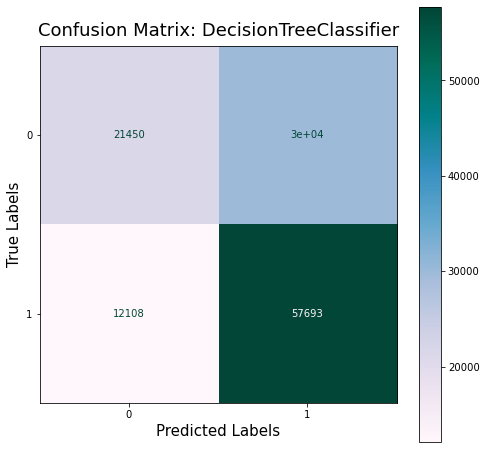

In [18]:
# Visualize confusion matric
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(dtc, X_test_transformed, y_test,
                      cmap=plt.cm.PuBuGn, ax=ax)
ax.set_title('Confusion Matrix: DecisionTreeClassifier', fontsize=18, pad=10)
ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15)

plt.grid(False)
plt.savefig(r'Graphs\DTC_confmatx.png', bbox_inches='tight')
plt.show();

AUC: 0.6215322773280627


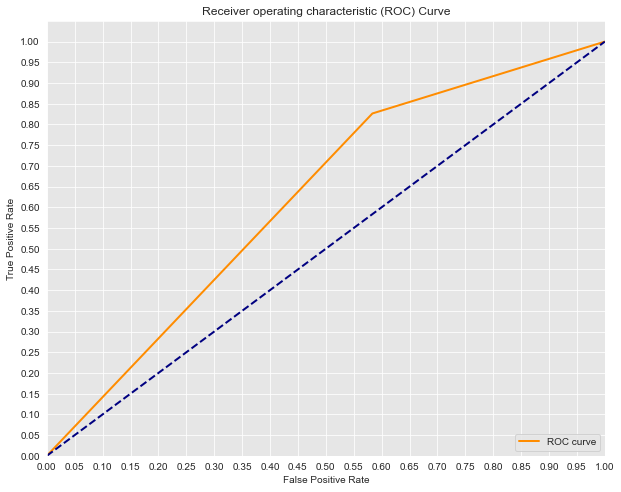

In [19]:
### ROC curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(r'Graphs\DTC_ROC.png', bbox_inches='tight')
plt.show();

Looking at the ROC, we can see that the model is only somewhat good at predicting the classes. The AUC of 0.62 suggests that there is a 62% probability that the model will correcty classify each target variable.

### Re-grow the tree using entropy

In [20]:
%%time
#Instantiate the model
dtc1 = DecisionTreeClassifier(criterion='entropy')

#Fit the model
dtc1.fit(X_train_transformed, y_train)

# Make predictions for train and test data
y_pred_train_dtc1 = dtc1.predict(X_train_transformed)
y_pred_test_dtc1 = dtc1.predict(X_test_transformed)

# Calculate accuracy 
train_acc1 = accuracy_score(y_train,y_pred_train_dtc1) * 100
test_acc1 = accuracy_score(y_test, y_pred_test_dtc1) * 100
print('Train accuracy is :{0}'.format(train_acc1))
print('Test accuracy is :{0}'.format(test_acc1))

# Check the AUC for predictions
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_test_dtc)
roc_auc1 = auc(fpr1, tpr1)
print('\nAUC is :{0}'.format(round(roc_auc1, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred_test_dtc, rownames=['True'], colnames=['Predicted'], margins=True)

Train accuracy is :90.31049931455544
Test accuracy is :63.048854886313045

AUC is :0.62

Confusion Matrix
----------------
Wall time: 2min 39s


Predicted,0,1,All
True,,,
0,21450,30047,51497
1,12108,57693,69801
All,33558,87740,121298


The infomarmation gain criterion 'entropy' does not seem to have made much of a difference. Although it trained well in the training data with over 90% accuracy, it was not able to generalize and predict the test set well. This means that the model has started to overfit.

Since, we will be calculationt the accuracy score and plotting the matrix multiple times, let's create a function to use it on different models.

In [21]:
def pred_score(clf):    
    # Make predictions on train and test data
    y_pred_train = clf.predict(X_train_transformed)
    y_pred_test = clf.predict(X_test_transformed)
    
    # Calculate accuracy 
    train_acc = accuracy_score(y_train,y_pred_train) * 100
    test_acc = accuracy_score(y_test, y_pred_test) * 100
    print('Train accuracy is :{0}'.format(train_acc))
    print('Test accuracy is :{0}'.format(test_acc))
    
    # Check the AUC for predictions
    roc_auc = roc_auc_score(y_test, y_pred_test)
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))
    
    # Create and print a confusion matrix 
    print('\nConfusion Matrix')
    print('-----------------')
    print(pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True))

    # Classification report
    print('\nClassification Report')
    print('----------------------')
    print(classification_report(y_test, y_pred_test))

### Model 1: KNN

In [22]:
# Instantiate and fit the model
knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)

KNeighborsClassifier()

In [23]:
pred_score(knn)

Train accuracy is :75.05017171445935
Test accuracy is :64.80156309254893

AUC is :0.63

Confusion Matrix
-----------------
Predicted      0      1     All
True                           
0          27514  23983   51497
1          18712  51089   69801
All        46226  75072  121298

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.60      0.53      0.56     51497
           1       0.68      0.73      0.71     69801

    accuracy                           0.65    121298
   macro avg       0.64      0.63      0.63    121298
weighted avg       0.64      0.65      0.64    121298



The KNN seems to be just a little better than our base mode at 65% accuracy and AUC score of 0.63.

### Model 2: Random Forest

In [24]:
# Instantiate and fit the model
rf = RandomForestClassifier(n_estimators=100, max_depth= 5)
rf.fit(X_train_transformed, y_train)  

RandomForestClassifier(max_depth=5)

In [25]:
pred_score(rf)

Train accuracy is :66.3888378534986
Test accuracy is :66.47924945176342

AUC is :0.62

Confusion Matrix
-----------------
Predicted      0       1     All
True                            
0          14843   36654   51497
1           4006   65795   69801
All        18849  102449  121298

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.79      0.29      0.42     51497
           1       0.64      0.94      0.76     69801

    accuracy                           0.66    121298
   macro avg       0.71      0.62      0.59    121298
weighted avg       0.70      0.66      0.62    121298



Looking at the train and test accuracy, the random forest model also shows a good fit of the data. The AUC is 0.62. The difference in f1-scores suggests that there is some bias in the data between the two classifiers.

### Feature Importance with Random Forest

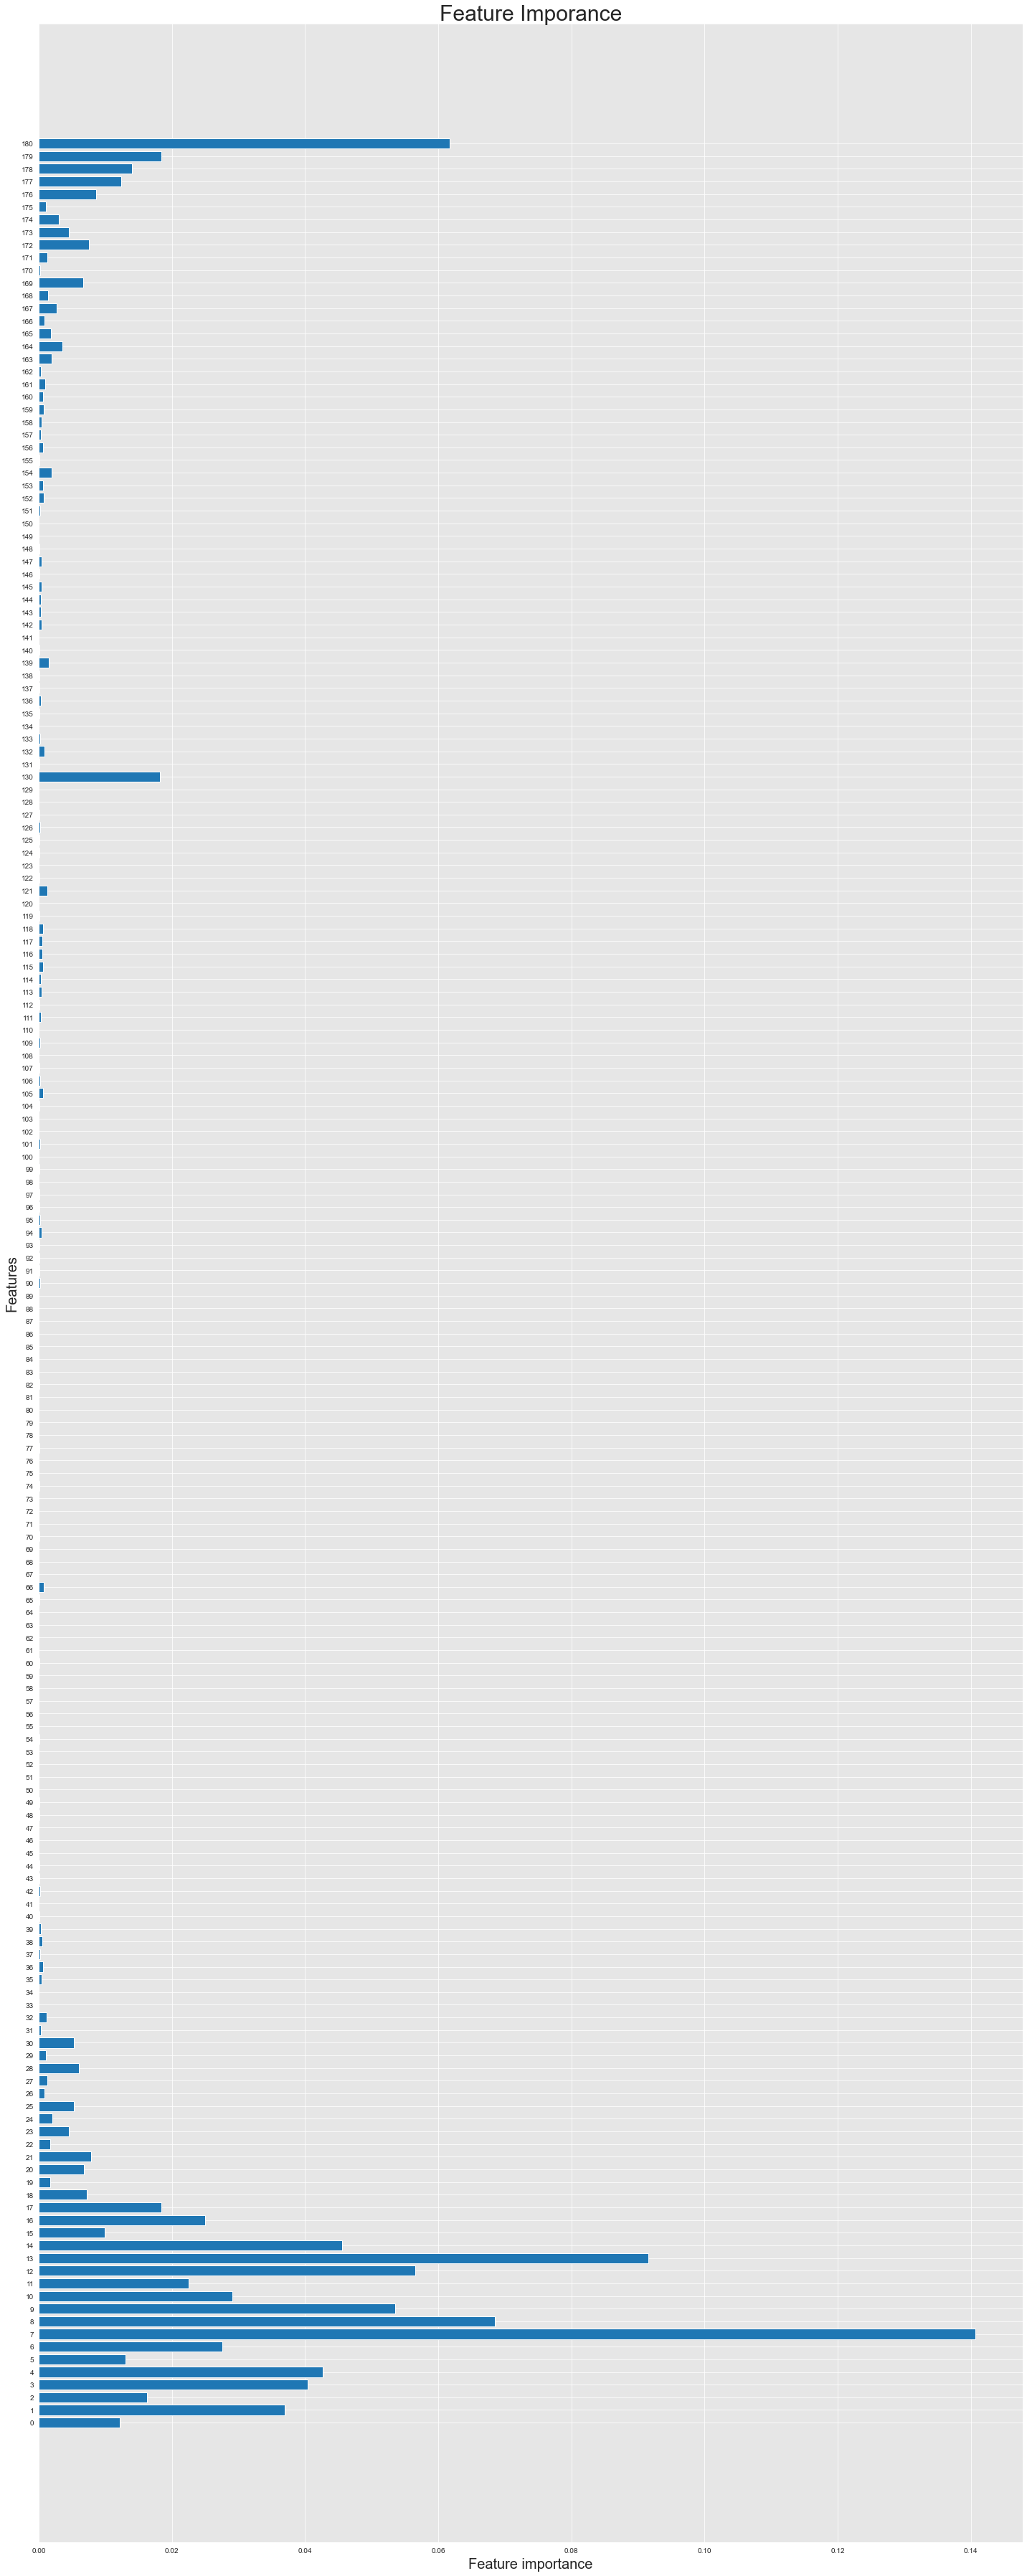

In [26]:
n_features = X_train_transformed.shape[1]
plt.figure(figsize=(20,50))
plt.barh(range(n_features), rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features))
plt.title('Feature Imporance', fontsize=30, pad=5)
plt.xlabel('Feature importance', fontsize=20, labelpad=5)
plt.ylabel('Features', fontsize=20)
plt.tight_layout()
plt.savefig(r'Graphs\feat_imp.png', bbox_inches='tight')

The feature importance gives us the distribution of how each feature is affecting the model. We can use then use this information to filter different predictors.

### Selecting best features

In [27]:
# Print the gini importance of each feature
for feature in zip(range(n_features), rf.feature_importances_):
    print(feature)

(0, 0.012198056093249705)
(1, 0.03698239370893893)
(2, 0.016233967336432547)
(3, 0.040341558721171844)
(4, 0.042682375019326806)
(5, 0.013057161487676668)
(6, 0.02754415892757339)
(7, 0.14069995496073995)
(8, 0.06853568059738646)
(9, 0.053510691237872485)
(10, 0.029099493346527495)
(11, 0.02248037377585717)
(12, 0.056550372824289555)
(13, 0.09153857636007269)
(14, 0.04552395433937566)
(15, 0.009932898221875087)
(16, 0.025010348485058544)
(17, 0.018381005954879414)
(18, 0.007228629332758746)
(19, 0.0016914176538951702)
(20, 0.006800139692032318)
(21, 0.007868128832391701)
(22, 0.0017500676192511132)
(23, 0.0045122690663912755)
(24, 0.0020464752769273555)
(25, 0.0052879197979732034)
(26, 0.0008907723123714113)
(27, 0.0012919144199776288)
(28, 0.006036780415818967)
(29, 0.0010354260223541373)
(30, 0.005276555239645327)
(31, 0.0003359019239305097)
(32, 0.0012237132049270445)
(33, 3.974988007523362e-05)
(34, 3.5485905250953906e-05)
(35, 0.0004304444724229541)
(36, 0.0006210088396308527)
(37

Let's plot the scores to visualize the scores.

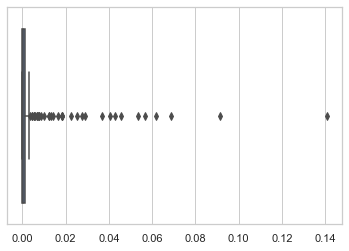

In [28]:
# Box plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=rf.feature_importances_)
plt.savefig(r'Graphs\box_plot.png', bbox_inches='tight');

Majority of the predictors seem to have feature importance of less than 0.01.

In [29]:
rf.feature_importances_.max()

0.14069995496073995

In [30]:
rf.feature_importances_.min()

0.0

Let's plot this on a normal distribution to see if we can extract more information.

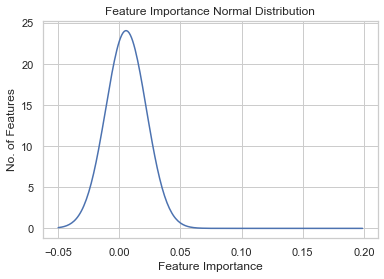

In [31]:
# Check the normal distribution of feature scores
from scipy.stats import norm
import statistics
  
# Plot between -0.05 and 0.2 with .001 steps.
x_axis = np.arange(-0.05,0.2,.001)
  
# Calculate mean and standard deviation
mean = statistics.mean(rf.feature_importances_)
sd = statistics.stdev(rf.feature_importances_)
  
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.title('Feature Importance Normal Distribution')
plt.ylabel('No. of Features')
plt.xlabel('Feature Importance')
plt.savefig(r'Graphs\norm_dist.png', bbox_inches='tight')
plt.show();

Here again, you can see that most of the features are centered between 0.00 and 0.025. The number of features fall sharply as the feature importance increases.

We will use a threshold of 0.01 to try and capture most of the predictors. 

In [32]:
thresh_1 = [x for x in rf.feature_importances_ if x > 0.01]
len(thresh_1)

22

Using a threshold of 0.01, we have 22 predictors to use in our model.

We will use the SelectFromModel to apply the 0.01 threshold and run the model. 

In [33]:
# Instantiate and fit the model
sfm = SelectFromModel(rf, threshold=0.01)

sfm.fit(X_train_transformed, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=5), threshold=0.01)

In [34]:
# Transform the data to create a new dataset containing only the most important features
X_best_train = sfm.transform(X_train_transformed)
X_best_test = sfm.transform(X_test_transformed)

In [35]:
# Instantiate and fit the model
rf_best = RandomForestClassifier(n_estimators=100, max_depth= 5)
rf_best.fit(X_best_train, y_train)

RandomForestClassifier(max_depth=5)

In [36]:
# Make predictions on train and test data
y_pred_train_rfb = rf_best.predict(X_best_train)
y_pred_test_rfb = rf_best.predict(X_best_test)
    
# Calculate accuracy 
train_acc_rfb = accuracy_score(y_train,y_pred_train_rfb) * 100
test_acc_rfb = accuracy_score(y_test, y_pred_test_rfb) * 100
print('Train accuracy is :{0}'.format(train_acc_rfb))
print('Test accuracy is :{0}'.format(test_acc_rfb))
    
# Check the AUC for predictions
roc_auc_rfb = roc_auc_score(y_test, y_pred_test_rfb)
print('\nAUC is :{0}'.format(round(roc_auc_rfb, 2)))
    
# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('-----------------')
print(pd.crosstab(y_test, y_pred_test_rfb, rownames=['True'], colnames=['Predicted'], margins=True))

# Classification report
print('\nClassification Report')
print('----------------------')
print(classification_report(y_test, y_pred_test_rfb))

Train accuracy is :67.69259578557597
Test accuracy is :67.69361407442827

AUC is :0.64

Confusion Matrix
-----------------
Predicted      0      1     All
True                           
0          19499  31998   51497
1           7189  62612   69801
All        26688  94610  121298

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.73      0.38      0.50     51497
           1       0.66      0.90      0.76     69801

    accuracy                           0.68    121298
   macro avg       0.70      0.64      0.63    121298
weighted avg       0.69      0.68      0.65    121298



Here, you can see a great fit with almost identical train and test accuracy scores. The AUC is also 0.64, which means that we are able to predict the target variables with similar success rate but with less features. The run time for the model has also decreased considerably. We will use these selected features going forward.

We will update our pred_score function to include the selected features train and test data.

In [37]:
# Define function for X_best datasets

def pred_score_best(clf):    
    # Make predictions on train and test data
    y_pred_train = clf.predict(X_best_train)
    y_pred_test = clf.predict(X_best_test)
    
    # Calculate accuracy 
    train_acc = accuracy_score(y_train,y_pred_train) * 100
    test_acc = accuracy_score(y_test, y_pred_test) * 100
    print('Train accuracy is :{0}'.format(train_acc))
    print('Test accuracy is :{0}'.format(test_acc))
    
    # Check the AUC for predictions
    roc_auc = roc_auc_score(y_test, y_pred_test)
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))
    
    # Create and print a confusion matrix 
    print('\nConfusion Matrix')
    print('-----------------')
    print(pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True))

    # Classification report
    print('\nClassification Report')
    print('----------------------')
    print(classification_report(y_test, y_pred_test))


### Model 3: XG Boost

In [38]:
# Instantiate and fit the model
xg = xgb.XGBClassifier()
xg.fit(X_best_train, y_train)

[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
pred_score_best(xg)

Train accuracy is :72.50731376400921
Test accuracy is :70.30618806575542

AUC is :0.68

Confusion Matrix
-----------------
Predicted      0      1     All
True                           
0          27740  23757   51497
1          12261  57540   69801
All        40001  81297  121298

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.69      0.54      0.61     51497
           1       0.71      0.82      0.76     69801

    accuracy                           0.70    121298
   macro avg       0.70      0.68      0.68    121298
weighted avg       0.70      0.70      0.70    121298



The accuracy scores are up to 72% and 70% for train vs test. The model seems to be a good fit. The AUC has also increased to 0.68. This has been our best scores so far. We will use this model and tune for better performance.

### Tuning XGBoost with GridSearchCV

We can use GridSearchCV to run the model with different iterations and come up with the parameters that gives us the best results.

First we will create a grid for the algorithm to loop through.

In [40]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6,12],
    'min_child_weight': [5,10],
    'subsample': [0.7,1.4],
    'n_estimators': [5, 30, 100, 250],
}

In [41]:
# Instantiate and fit the model
grid_clf = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_best_train, y_train)

[00:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[00:24:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:24:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                            

In [42]:
# Print the best parameters
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7


In [43]:
# Calcualte the score
pred_score_best(grid_clf)

Train accuracy is :72.35291207937024
Test accuracy is :70.5493907566489

AUC is :0.68

Confusion Matrix
-----------------
Predicted      0      1     All
True                           
0          27731  23766   51497
1          11957  57844   69801
All        39688  81610  121298

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.70      0.54      0.61     51497
           1       0.71      0.83      0.76     69801

    accuracy                           0.71    121298
   macro avg       0.70      0.68      0.69    121298
weighted avg       0.70      0.71      0.70    121298



Using the tuned paramenters, the model shows slightly increase in accuracy and AUC scores. The rest of metrics are almost identical to the regular XGBoost model. We might have reached the highest level of precision with this transformed dataset. We will keep this as our final model.

Finally, the model is a good fit as the test accuracy is slightly lower than the train accuracy at 70.5%. The AUC score is 0.68 with f1-score of 0.61 an 0.76 for target variables 0 and 1 respectively.

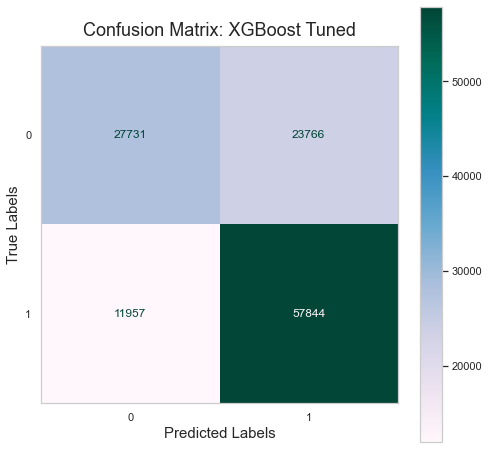

In [44]:
# Visualize confusion matric
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(grid_clf, X_best_test, y_test,
                      cmap=plt.cm.PuBuGn, ax=ax)
ax.set_title('Confusion Matrix: XGBoost Tuned', fontsize=18, pad=10)
ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15)

plt.grid(False)
plt.savefig(r'Graphs\xbg_confmatx.png', bbox_inches='tight')
plt.show();

### Conclusion

We can conclude our final M/L classifer to be the tuned XGBoost model. Looking at the results, we can derive the following conclusions:

* The model has an overall accuracy of 71% and an AUC of 0.68.


* **Precision** gives us the number of times the model was able to correctly classify each category without the penalty of it being incorrect. Both 'Unintenational' and 'Intentional' catergories were classified about 70% of the time correctly.


* **Recall** gives us the exact percentage of each category that the model was able to capture. For '0' or 'Unintentional', the model was only able to only categorize 54% of those present in our data. While for '1' or 'Intenational', the model was able to categorize about 76% of those present in our data. 


* **F1-Score** is the harmonic mean between Precision and Recall. It is a better measure for model accuracy since it incorporates both precision and recall scores. In our final model, we have a f1-score of 0.61 and 0.76 for each of our categories respectively. We can use this as a final measure of our model's performance. From the difference, we can also infer that there might be some class imbalances between the two categories.